## Population parameters inference using detected sources (from lists)

\begin{equation}
    r(\boldsymbol{\vartheta}; \mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)
    =
       \frac{p(\boldsymbol{\vartheta}|\mathbb{I}=1)}{p(\boldsymbol{\vartheta})}
    = \frac{p(\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1|\boldsymbol{\vartheta})}{p(\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)}\\
    = \int d\vec{\boldsymbol{s}}_{det} \frac{p(\vec{\boldsymbol{s}}_{det}|\boldsymbol{\vartheta})} {p(\vec{\boldsymbol{s}}_{det})}
    \frac{p(\vec{\boldsymbol{s}}_{det})\mathbb{I}(\vec{\boldsymbol{s}}_{det})}{p(\mathbb{I}(\vec{\boldsymbol{s}}_{det})=1)}
    = \int d\vec{\boldsymbol{s}}_{det} 
    %
    \underbrace{\frac{p(\vec{\boldsymbol{s}}_{det}|\boldsymbol{\vartheta})}{p(\vec{\boldsymbol{s}}_{det})}}_{
    \equiv {\color{teal}{r_4(\vec{\boldsymbol{s}}_{det};\boldsymbol{\vartheta})}}}
    %
    p(\vec{\boldsymbol{s}}_{det}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})= 1) 
    \;
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
from networks import NetworkSensitivity, NetworkParamList
import sims
import skimage

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

### Simulate with bounds

Load back model for r_2

In [3]:
simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original_d.zarr")

def hook(out):
    N = int(out['pdp'][0])
    idx = torch.randint(N, (1,)) # index in simulated source range
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    # make sure to pick source simulated in image
    while torch.sum((out['source'][:2]>40)+(out['source'][:2]<-40), -1):
        idx = torch.randint(N, (1,)) # index in simulated source range
        out['source'] = torch.from_numpy(out['pdc'][idx]) # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    out['d_source'] = np.array([out['d'][idx]])*1. # (1,)   
    out = sl.to_numpy32(out)
    return out

dl_test = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample=hook)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_sensitivity/version_0/checkpoints/model.yaml")
network_d = NetworkSensitivity()
trainer.test(network_d, dl_test, ckpt_path = ckpt_path);

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.04079096019268036
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


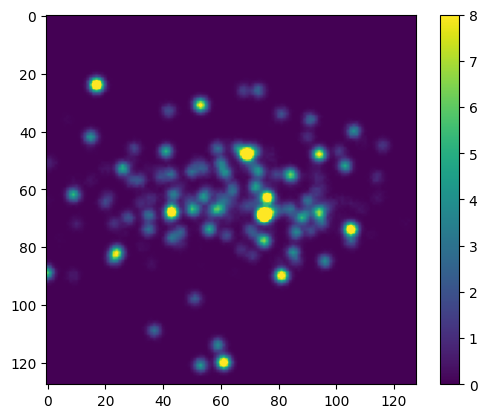

In [4]:
threshold= 5
psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = threshold)
simulator = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)

plt.imshow(simulator.sample()['data'], vmax = 8)
plt.colorbar();

In [5]:
shapes, dtypes = simulator.get_shapes_and_dtypes()
zs = swyft.ZarrStore(f"/project/fermi_data/neurips_bounded.zarr").init(50000, 64, shapes, dtypes)
zs.simulate(simulator, batch_size = 500)

Resample noise and PSF

In [6]:
from scipy.ndimage import gaussian_filter

def hook(out):
    out['mu'] =  gaussian_filter(out['mu_psc'], 1.5)*4   # resample psf
    out['data'] = np.random.poisson(out['mu']*100)/100  # resample noise
    out = sl.to_numpy32(out)
    return out


dl_train = zs.get_dataloader(idx_range = [0, 36000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)
dl_val = zs.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)

### Train for population hyperparameters using PSs lists

In [7]:
logger = TensorBoardLogger("./lightning_logs", name = 'neurips_params_list', version=None)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", save_top_k=1, mode="min",)

trainer = swyft.SwyftTrainer(
    accelerator = 'gpu', 
    gpus=1, 
    max_epochs = 100, 
    logger = logger, 
    callbacks = [checkpoint_callback]
)

network_param_list = NetworkParamList(lr=1e-3, lrs_factor = 0.1, lrs_patience = 3, early_stopping_patience = 5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
# trainer.fit(network_param_list, train_dataloaders = dl_train, val_dataloaders = dl_val)

In [9]:
# checkpoint_callback.to_yaml(checkpoint_callback.dirpath+"/model.yaml")
# ckpt_path = swyft.best_from_yaml(checkpoint_callback.dirpath+"/model.yaml")
ckpt_path = swyft.best_from_yaml(f"./lightning_logs/neurips_params_list/version_0/checkpoints/model.yaml")

print(ckpt_path)
trainer.test(network_param_list, dl_val, ckpt_path = ckpt_path)

Restoring states from the checkpoint path at ./lightning_logs/neurips_params_list/version_0/checkpoints/epoch=13-val_loss=-5.36.ckpt


./lightning_logs/neurips_params_list/version_0/checkpoints/epoch=13-val_loss=-5.36.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_params_list/version_0/checkpoints/epoch=13-val_loss=-5.36.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -5.340162754058838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -5.340162754058838}]

### Inference

The ratio estimates 

\begin{equation}
    r_4(\vec{\boldsymbol{s}}_{det};\boldsymbol{\vartheta}) = \frac{
    p(\vec{\boldsymbol{s}}_{det}|\boldsymbol{\vartheta})
    }{
    p(\vec{\boldsymbol{s}}_{det})
    }
\end{equation}

we need to evaluate the integral over the allowed regions in the exclusion maps:

\begin{equation}
\int \frac{
    p(\vec{\boldsymbol{s}}_{det}|\boldsymbol{\vartheta})
    }{
    p(\vec{\boldsymbol{s}}_{det})
    }
    p(\vec{\boldsymbol{s}}_{det}|\mathbb{I}(\vec{\boldsymbol{s}}_{det})= 1) 
\end{equation}

In [10]:
psc_det = torch.tensor(np.load('neurips_ps_det.npy'))
bounds = sims.ToyFermiBound(detected = psc_det, threshold = threshold)
simulator = sims.ToyFermiSensitivity(npix = 128, bounds=bounds, sensitivity_function=network_d)

A = simulator.sample(10000, targets=['pdcd'])
A['pdcr'] = A['pdcd'] # trick labels

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1560.05it/s]


In [11]:
s0 = np.load('obs.npy', allow_pickle=True).item()
truth = {f'pdp[{i}]': s0['pdp'][i] for i in range(3)}
labeler = {'pdp[0]': r"N", 'pdp[1]': r"$\sigma_\mathrm{flux}$", 'pdp[2]': "h"}
B = simulator.sample(10000, targets=['pdp'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29221.51it/s]


In [12]:
out = trainer.infer(network_param_list, A, B)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


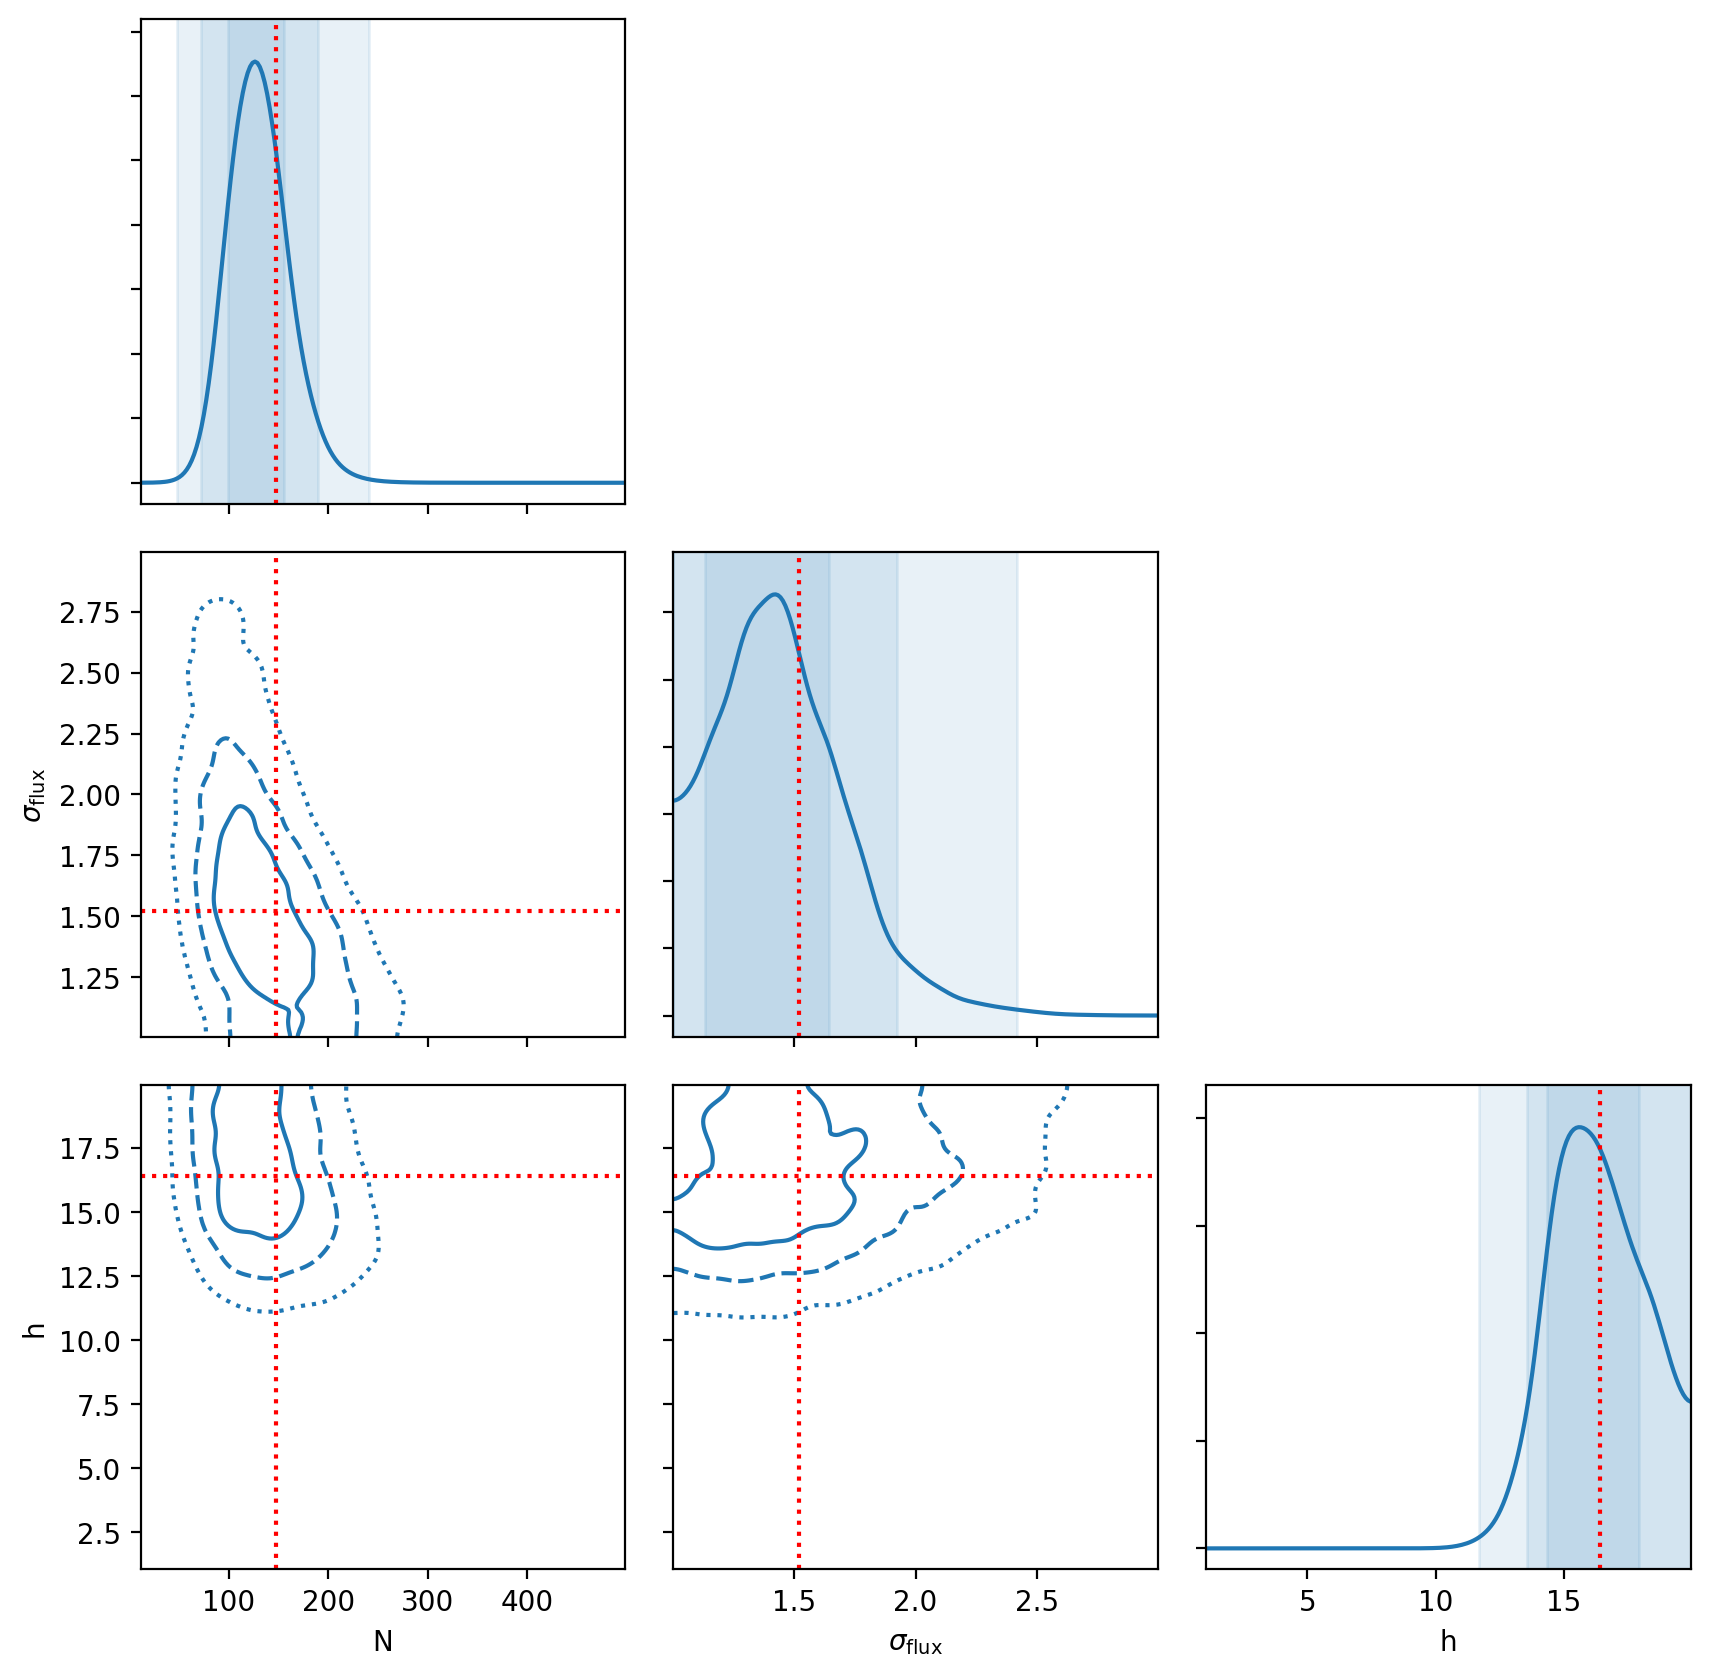

In [13]:
swyft.corner((out['re_param'],out['re_param2'],), ('pdp[0]', 'pdp[1]', 'pdp[2]'), 
             truth=truth, labeler=labeler, 
             bins = 200, smooth = 5, color='tab:blue');

### Test

In [14]:
pdcc = zs['pdcc'][-1000:]
pdcr = zs['pdcr'][-1000:]
pdp = zs['pdp'][-1000:]
data = zs['data'][-1000:]

samples = swyft.Samples(data=data, pdp=pdp, pdcc=pdcc, pdcr=pdcr)

In [15]:
coverage_samples = trainer.test_coverage(network_param_list, samples, B)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

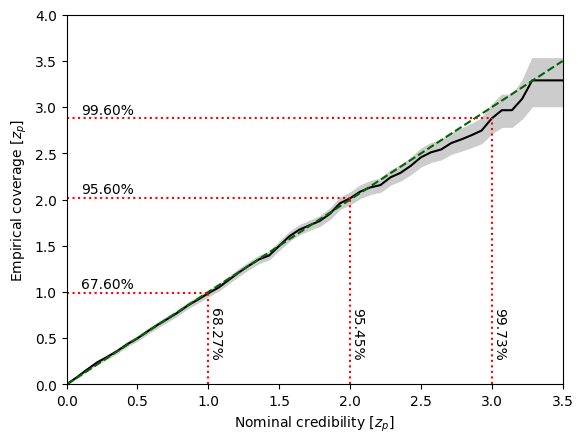

In [16]:
swyft.plot_zz(coverage_samples, 'pdp[0]')

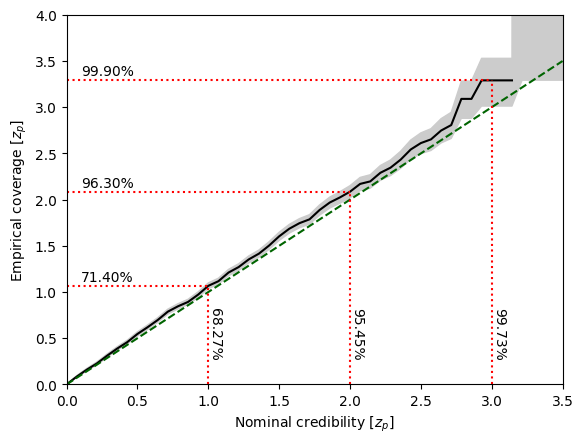

In [17]:
swyft.plot_zz(coverage_samples, 'pdp[1]')

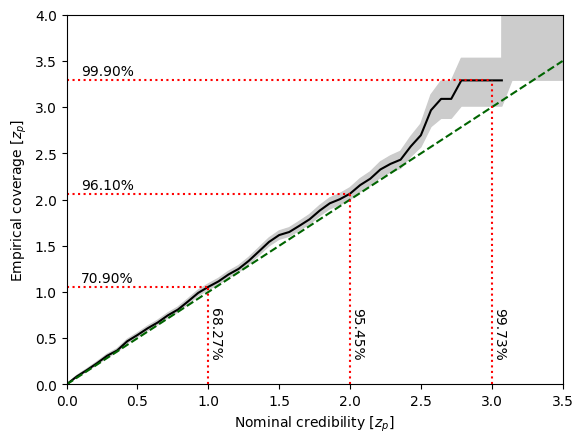

In [18]:
swyft.plot_zz(coverage_samples, 'pdp[2]')

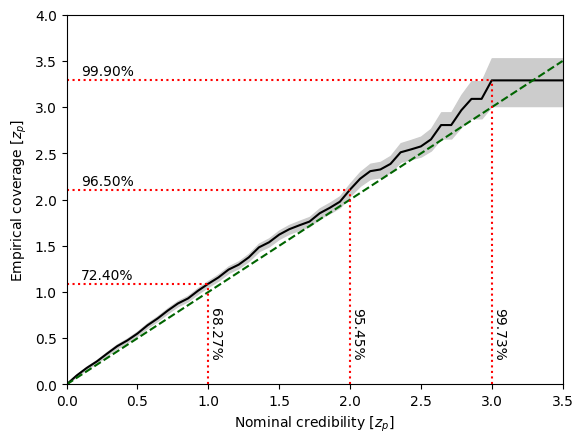

In [19]:
swyft.plot_zz(coverage_samples, 'pdp[0]', 'pdp[1]')

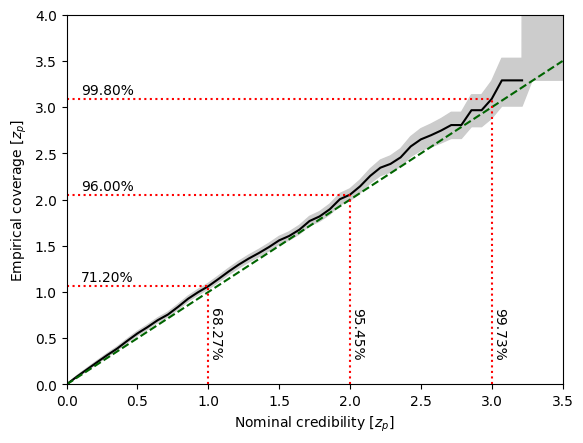

In [20]:
swyft.plot_zz(coverage_samples, 'pdp[0]', 'pdp[2]')

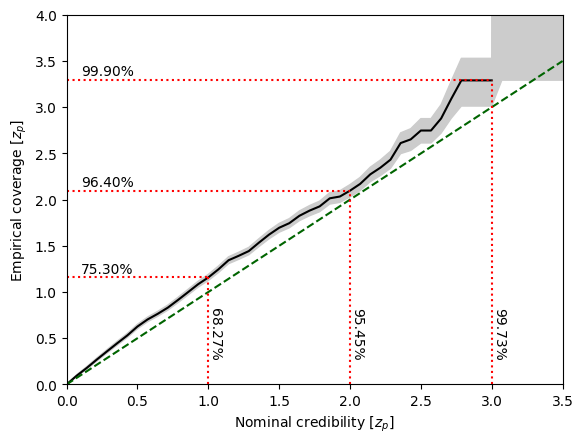

In [21]:
swyft.plot_zz(coverage_samples, 'pdp[1]', 'pdp[2]')